# Feature Construction
Generate the class values, i.e. the y for the data. Construct features

## Parameters
Here, all parameters of the notebook are set

In [1]:
#Load stock market files 
filename = '01_Source/Source_OMX1986-2019.CSV'
filedataresultdirectory = "02_Training_Data"
#filename = '01_Source/Source_OMX2017-2019_testset.CSV'
#filedataresultdirectory = "03_Test_Prepared_Data"

dataset_name = "omxs30"
class_name = "LongTrend"

filenameprefix = dataset_name + "_" + class_name
filenamesuffix = ""

dataset_filename = filedataresultdirectory + "/" + filenameprefix + "_dataset" + filenamesuffix + ".csv"
ylabel_filename = filedataresultdirectory + "/" + filenameprefix + "_y" + "_labels" + filenamesuffix + ".csv"
source_filename = filedataresultdirectory + "/" + filenameprefix + "_timegraph" + filenamesuffix + ".csv"

#Allow cropping of data, which are longer than moving averages in the future. For training data, this value shall be 
#true to not make false values. For the test values, which do not use any y values, the value shall be false.
cut_data = True

## Load Raw Data
Stock data will be loaded, train and test values will be calculated to be used as Y values for the system

<IPython.core.display.Javascript object>


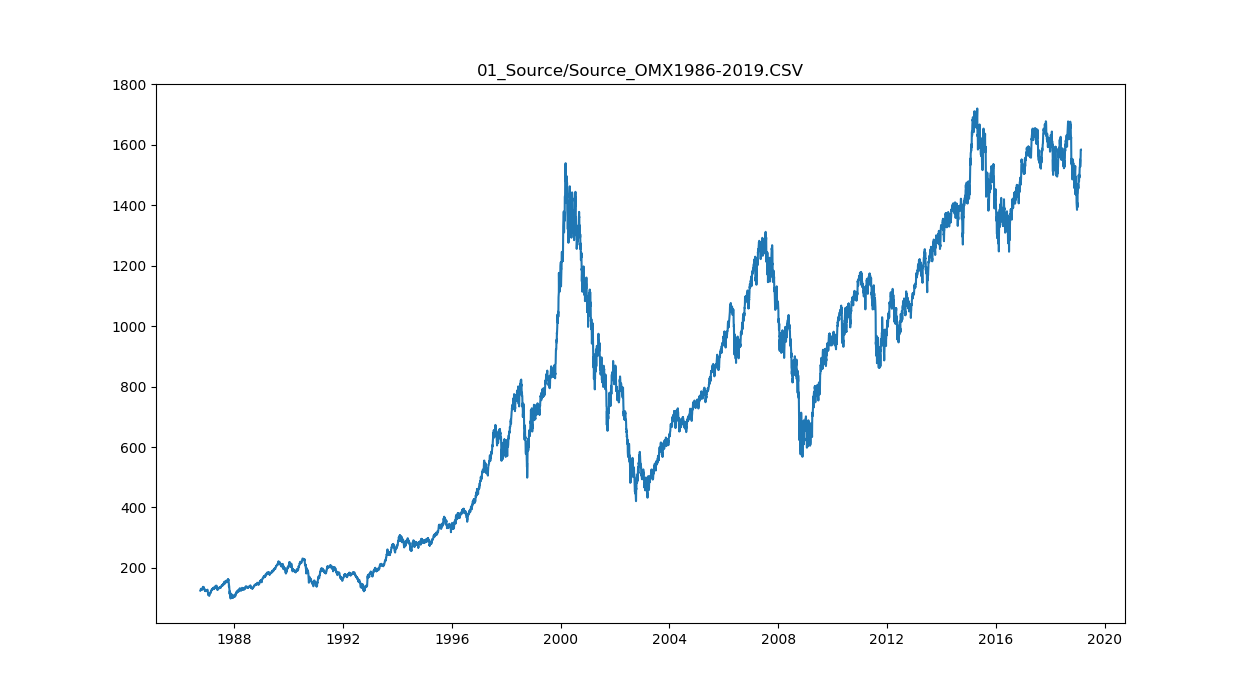

In [2]:
%matplotlib notebook

import pandas as pd
import numpy as np
# import pandas_datareader as datareader
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
#from matplotlib.finance import candlestick_ohlc
# from mpl_finance import candlestick_ohlc

#%matplotlib inline
#%matplotlib notebook
#%matplotlib ipympl

df = pd.read_csv(filename, sep=';')
df.index.name = "id"
df.columns = ['Time', 'High', 'Low', 'Close']
df['Time'] = pd.to_datetime(df['Time'])
df['Time'].apply(mdates.date2num)
#df.head()

plt.figure(num=None, figsize=(12.5, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df['Time'],df['Close'])
plt.title(filename)
plt.show()

### Time Series Autocorrelation Matrix

In [3]:
# If time series are used, apply auto correlation to see how many values are relevant for moving averages

## Class Generation

### Calculate Tops and Bottoms

In [4]:
m=df.shape[0]
factor = 10000000
topsTemp = np.zeros([m, 4]);
topsTemp
bottomsTemp = np.ones([m, 4])*factor;
bottomsTemp
#close=df['Close']
#close

array([[10000000., 10000000., 10000000., 10000000.],
       [10000000., 10000000., 10000000., 10000000.],
       [10000000., 10000000., 10000000., 10000000.],
       ...,
       [10000000., 10000000., 10000000., 10000000.],
       [10000000., 10000000., 10000000., 10000000.],
       [10000000., 10000000., 10000000., 10000000.]])

In [5]:
# Get tops and bottoms from the chart
#Parameter
maxDecline = 0.02
maxIncrease = 0.02
factor = 10000000

#Format: Time, High, Low, Close
m=df.shape[0]

topsTemp = np.zeros([m, 4])
bottomsTemp = np.ones([m, 4])*factor

high=df['High']
low=df['Low']
close=df['Close']

#Run 1 for the rough tops and bottoms
for i, data in enumerate(df.values):
    #Get top
    if i>3 and i<m-3:
        #Decline close >2% from top high
        decline = (high[i] - min(close[i+1:i+2]))/high[i];
        if decline > maxDecline or high[i]==max(high[i-3:i+3]):
            #Top found
            topsTemp[i, 1]=high[i];
            #print("Top found at i={} value={}".format(i, high[i]));
    
    #%Get bottom
    if i>3 and i<m-3:
    #    %Decline close >2% from top high
        increase = (low[i] - max(close[i+1:i+2]))/low[i];
        if increase > maxIncrease or low[i]==min(low[i-3:i+3]):
            #Top found
            bottomsTemp[i, 1]=low[i];
            #print("Bottom found at i={} value={}".format(i, low[i]));

print("{} tops, {} bottoms found.".format(sum(topsTemp[:, 1]>0), sum(bottomsTemp[:, 1]<factor)));

#%Run 2 for exacter tops and bottoms
iTop = topsTemp[:,1];
iBottom = bottomsTemp[:,1];
for i, data in enumerate(df.values):
    #Tops
    if i>20 and i<m-20:
        if iTop[i]>0 and max(iTop[i-15:i+15])<=iTop[i]:
            topsTemp[i, 2]=iTop[i];
            #%fprintf("Intermediate top found at i=%i value=%.0f\n", i, iTop(i));
    
        if iBottom[i]<factor and min(iBottom[i-15:i+15])>=iBottom[i]:
            bottomsTemp[i, 2]=iBottom[i];
            #%fprintf("Intermediate bottom found at i=%i value=%.0f\n", i, iBottom(i));

bottomsTemp[bottomsTemp==factor]=0
bottoms=bottomsTemp[:, 2]
tops=topsTemp[:, 2]
print("Reduced to {} tops and {} bottoms.".format(sum(tops[:]>0), sum(bottoms[:]>0)));

1739 tops, 1237 bottoms found.
Reduced to 193 tops and 222 bottoms.


In [6]:
#topsTemp[topsTemp[:,1]>0]

In [7]:
#bottomsTemp[0:10,:]

<IPython.core.display.Javascript object>


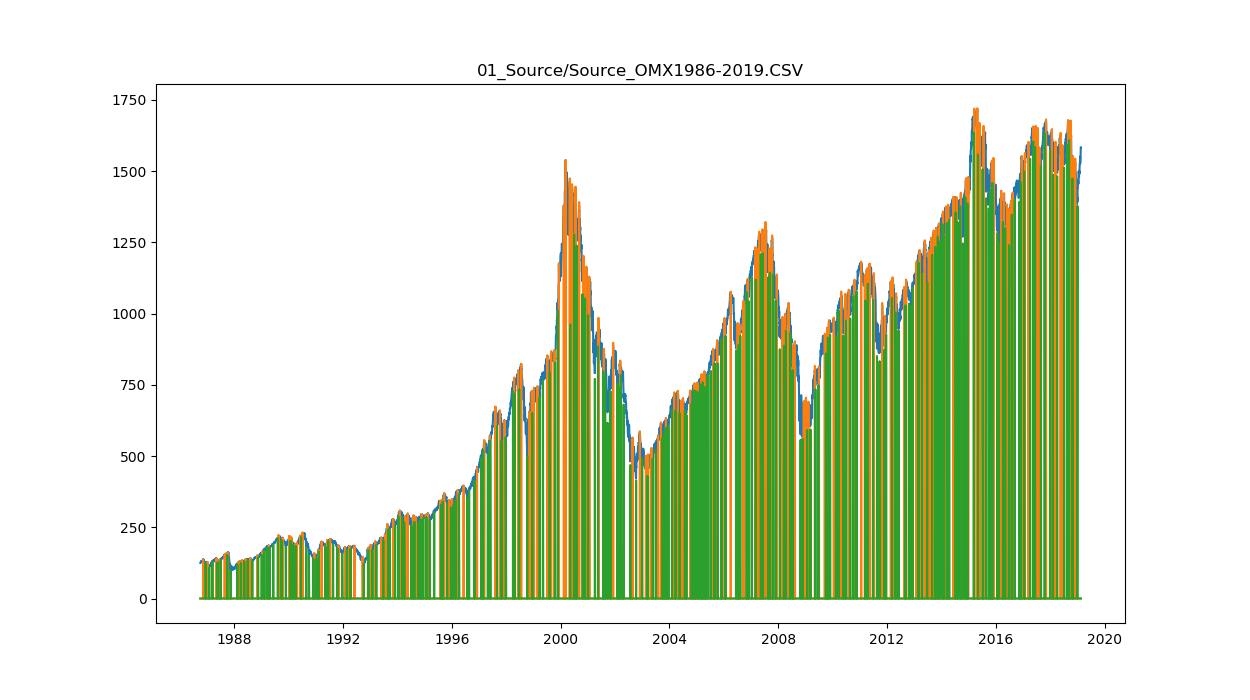

In [8]:
plt.figure(num=None, figsize=(12.5, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df['Time'],df['Close'])
plt.plot(df['Time'], tops[:])
plt.plot(df['Time'], bottoms[:])
plt.title(filename)
plt.show()

In [9]:
#Calculate the latest single event from a list of [0 0 0 0 2 0 0 1 0]->[0 0 0 0 2 2 2 2 1 1]
def calculateLatestEvent(eventList):
    previousItem=0;
    result = np.zeros(eventList.shape[0])
    for i in range(len(eventList)):
        if eventList[i]!=previousItem and eventList[i]!= 0:
            result[i]=eventList[i]
            previousItem=eventList[i]
        else: 
            result[i]=previousItem
    return result

latestBottoms = calculateLatestEvent(bottoms)
latestTops = calculateLatestEvent(tops)

In [10]:
#Calculate varios MA
#mov = pd.Series(np.arange(0, 100, 1), name='test')
#print(mov)
#Moving Average 
# mov: close
# n: Number of samples
# shift: shift of the window. shift < 0 future, shift > 0 history
def MA(mov, n, shift):  
    MA = mov.rolling(n).mean()
    #print(MA)
    df=pd.DataFrame(MA)
    df.columns = ['SMA' + str(n) + 'shift' + str(shift)]
    shiftedMA = df.shift(shift)
    
    return shiftedMA

In [11]:
ma50Future = MA(close, 50, -50)

In [12]:
#Use Lowess to create a smoothed trend as an y value

from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
from scipy.ndimage.interpolation import shift

#Fraction for the lowess smoothing function
frac=300/len(df['Close'])
filtered = lowess(df['Close'], df['Time'], frac=frac)
#Calculate the dlowess/dt to see if it is raising or declining
shiftCol = filtered[:,1] - shift(filtered[:,1], 1, cval=np.NaN)
pos_trend = shiftCol>0
print(pos_trend[0:5])

[False  True  True  True  True]


C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


### Calculate the Y values for 1d, 5d, 20d and the Long Trend

In [13]:
#Calculte the 1d trend

high=df['High']
low=df['Low']
close=df['Close']

y1day=np.zeros(m)
#Calculate the 5d trend
y5day=np.zeros(m)
#20d trend
y20day=np.zeros(m)
#long term trend
ylong=np.zeros(m)
signalLong=0;

for i in range(m-50):
    if close[i+1]>close[i]:
        y1day[i]=1
    
    if close[i+5]>close[i]:
        y5day[i]=1;
    
    if close[i+20]>close[i]:
        y20day[i]=1;
    
    #long term
    #Trigger buy
    if pos_trend[i] == True and close[i]>latestTops[i]:
        signalLong=1;
    elif close[i]<latestBottoms[i] and pos_trend[i] == False:
        signalLong=0;
    
    #old
    #if close[i] < ma50Future.iloc[i,0] and close[i]>latestTops[i]:
    #    signalLong=1;
    #elif close[i]<latestBottoms[i] and close[i] > ma50Future.iloc[i,0]:
    #    signalLong=0;
        
    if signalLong==1:
        ylong[i] = 1;
    else:
        ylong[i] = 0;

print("y1day", sum(y1day))
print("y5day", sum(y5day))
print("y20day", sum(y20day))
print("ylong", sum(ylong))
print("Generated trends 1d, 5d, 20d, long.")

y1day 4254.0
y5day 4517.0
y20day 4771.0
ylong 5455.0
Generated trends 1d, 5d, 20d, long.


In [14]:
#Clean bad signals 1
previousSignalCount = sum(y1day)
for i in range(m-50):
    #If the signal is only valid for one or 2 days the signal was bad and
    #noisy. Only if the signal is valid for 3 days, it can be consideres as
    #a real signal
    if np.mean(y1day[i:i+3])<0.75:
        y1day[i]=0

print("Previous signal count y1day={}. New signal count={}".format(previousSignalCount, sum(y1day)))
print("Cleaned bad signals 1");

Previous signal count y1day=4254.0. New signal count=1215.0
Cleaned bad signals 1


In [15]:
#Clean bad signals 2, filter single days, enhance trend
print("signals y1day=", sum(y1day))
print("signals ylong=", sum(ylong))

#for i in range(m-50):
    # short term +1d
    #if i>1 and y1day[i-1]==0 and y1day[i+1]==0:
    #    y1day[i]=0;
    
    #long term, remove all values < 5 days to remove noise
    #use sliding window
    #if i>5 and ylong[i]==1:
    #    slideresult = np.zeros(5);
    #    for j in range(-5,0):
    #        slideresult[j+5] = np.mean(ylong[i+j:i+j+4])
    #    
    #    if max(slideresult)<1:
    #        ylong[i]=0;

print("signals y1day=", sum(y1day))
print("signals ylong=", sum(ylong))
print("Cleaned bad signals 2");

signals y1day= 1215.0
signals ylong= 5455.0
signals y1day= 1215.0
signals ylong= 5455.0
Cleaned bad signals 2


In [16]:
#Clean bad signals 3, filter single days
print("signals ylong=", sum(ylong))
for i in range(m-50):
    #long term, fill in all values < 5 days to remove noise
    #Fill gaps
    #Use sliding window
    if i>20-1 and ylong[i]==0 and np.mean(ylong[i-20:i+20])>0.5:
        ylong[i]=1;
    
    #Enhance the trend to run as far as possible
    if i>=1 and ylong[i-1]==1 and ylong[i]==0 and close[i]>latestBottoms[i]:
        ylong[i]=1;

print("signals ylong=", sum(ylong))
print("Cleaned bad signals 3.");

signals ylong= 5455.0
signals ylong= 5455.0
Cleaned bad signals 3.


In [17]:
#Merge all y values to the series start
merged_df=df.join(pd.Series(y1day, name="1dTrend").astype('int64')).join(
    pd.Series(y5day, name="5dTrend").astype('int64')).join(
    pd.Series(y20day, name="20dTrend").astype('int64')).join(
    pd.Series(ylong, name="LongTrend").astype('int64'))
#result = [source array2table([tops bottoms y1day y5day y20day ylong], 'VariableNames',{'Tops', 'Bottoms', 'answer1d', 'answer5d', 'answer20d', 'answerLong'})];
#result(end-100:end,:)=[];

In [18]:
if cut_data == True:
    #Drop the 50 last values as they cannot be used for prediction as +50 days ahead is predicted
    merged_df.drop(merged_df.tail(50).index, inplace=True)
    #Drop from the timerows too
    df.drop(df.tail(50).index, inplace=True)

#fprintf("Finish\n");
display(merged_df.head())
display(merged_df.tail())
#merged_df.shape
#df.shape

,Time,High,Low,Close,1dTrend,5dTrend,20dTrend,LongTrend
id,,,,,,,,
0,1986-09-30,125.00,125.00,125.00,1,1,1,0
1,1986-10-01,125.93,125.93,125.93,1,1,1,1
2,1986-10-02,126.25,126.25,126.25,1,1,1,1
3,1986-10-03,126.68,126.68,126.68,1,1,1,1
4,1986-10-06,128.15,128.15,128.15,0,0,1,1


,Time,High,Low,Close,1dTrend,5dTrend,20dTrend,LongTrend
id,,,,,,,,
8082,2018-11-27,1505.07,1490.76,1496.41,0,1,0,0
8083,2018-11-28,1505.74,1493.12,1500.45,0,0,0,0
8084,2018-11-29,1518.62,1501.65,1515.38,0,0,0,0
8085,2018-11-30,1519.18,1509.22,1514.63,0,0,0,0
8086,2018-12-03,1544.39,1523.88,1529.78,0,0,0,0


In [19]:
def amplifyForPlot(binaryArray, targetArray, distance):
    return binaryArray * targetArray * (1-distance)
#amplifyForPlot(merged_df['LongTrend'], merged_df['Close'], 0.01)

<IPython.core.display.Javascript object>


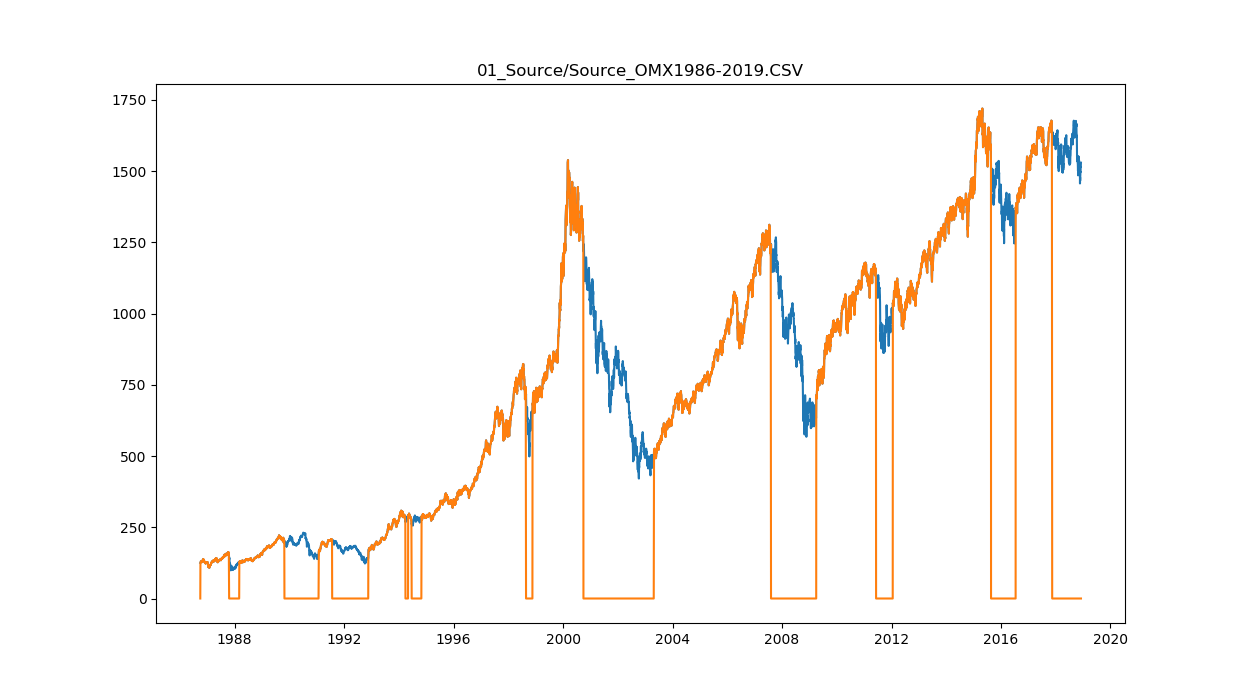

In [20]:
plt.figure(num=None, figsize=(12.5, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df['Time'],df['Close'])
plt.plot(df['Time'],amplifyForPlot(merged_df['LongTrend'], df['Close'], 0.00))
plt.title(filename)
plt.show()

## Generate Features from Raw Data
Generate features based on price data X

In [21]:
#Inputs
close = merged_df['Close']
high = merged_df['High']
low = merged_df['Low']
yCol = merged_df['LongTrend'];

In [22]:
#Technical indicators necessary
SMA200 = MA(close, 200, 0)
#bollinger = indicators(priceCol,'boll');
#rsi7=calc_RSI(priceCol,7)/100;
#rsi7 = [zeros(7,1);rsi7'];
#SMA200.fillna(0, inplace=True)
#SMA200

features = pd.DataFrame(index=merged_df.index)

### Generate mean values

In [23]:
# Generate features - Mean value 
meanList = [2, 5, 10, 18, 20, 40, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400];
#meanList = [5 10 20 50 100 1 50 200]';
#meanList = [5, 10, 20, 50, 100, 200];
#meanList = [5]

meanfeatures = pd.DataFrame(index=merged_df.index)

for i in meanList:
    #Mean
    meanCol=MA(close, i, 0); #Trailing MA with i
    #meanCol.fillna(0, inplace=True)
    meanColreshaped = np.reshape(meanCol.values, (1,np.product(meanCol.values.shape)))[0]
    #Calculate diff from price in %
    diffPriceCol = np.divide(meanColreshaped - close.values, close.values)
    temp_df = pd.DataFrame(diffPriceCol, columns=['MA' + str(i) + 'Norm'])
    #print(temp_df)
    meanfeatures = meanfeatures.join(temp_df)
    #meanTable(:,i) = diffPriceCol;
    #print("Calculated MA{}".format(i));
display(meanfeatures.head())

,MA2Norm,MA5Norm,MA10Norm,MA18Norm,MA20Norm,MA40Norm,MA50Norm,MA75Norm,MA100Norm,MA125Norm,...,MA175Norm,MA200Norm,MA225Norm,MA250Norm,MA275Norm,MA300Norm,MA325Norm,MA350Norm,MA375Norm,MA400Norm
id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.003693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.001267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.001697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.005735,-0.01364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Generate mean value directions

In [24]:
#Create empty dataframe for the differences between the current time and previous time
madiff_features = pd.DataFrame(index=features.index)

for col in meanfeatures.columns:
    currentCol = meanfeatures[col]
    shiftCol = meanfeatures[col].shift(1)
    diff = currentCol-shiftCol
    diff.name = col + 'Diff'
    #display(currentCol)
    #display(shiftCol)
    madiff_features = madiff_features.join(diff)
display(madiff_features.head())

,MA2NormDiff,MA5NormDiff,MA10NormDiff,MA18NormDiff,MA20NormDiff,MA40NormDiff,MA50NormDiff,MA75NormDiff,MA100NormDiff,MA125NormDiff,...,MA175NormDiff,MA200NormDiff,MA225NormDiff,MA250NormDiff,MA275NormDiff,MA300NormDiff,MA325NormDiff,MA350NormDiff,MA375NormDiff,MA400NormDiff
id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.002425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.000430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.004038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Generate RSI

In [25]:
from talib import RSI

rsiList = [2, 5, 14, 20, 25];

rsi_features = pd.DataFrame(index=features.index)

for i in rsiList:
    #RSI
    rsiCol=RSI(close, timeperiod=i)
    #Make df
    temp_df = pd.DataFrame(rsiCol, columns=['RSI' + str(i)])
    #print(temp_df)
    rsi_features = rsi_features.join(temp_df)
    #print("Calculated RSI{}".format(i))
display(rsi_features.head(10))

,RSI2,RSI5,RSI14,RSI20,RSI25
id,,,,,
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,100.000000,NaN,NaN,NaN,NaN
3,100.000000,NaN,NaN,NaN,NaN
4,100.000000,NaN,NaN,NaN,NaN
5,100.000000,100.000000,NaN,NaN,NaN
6,100.000000,100.000000,NaN,NaN,NaN
7,82.754904,94.039103,NaN,NaN,NaN
8,29.191696,67.343977,NaN,NaN,NaN


### Generate Stochastic

In [26]:
from talib import STOCH

slowk, slowd = STOCH(high, low, close, fastk_period=13, slowk_period=3, slowk_matype=0, slowd_period=8, slowd_matype=0)

stoch_features = pd.DataFrame(index=features.index)
stoch_features = stoch_features.join(pd.DataFrame(slowk, columns=['Stoch_slowk13']))
stoch_features = stoch_features.join(pd.DataFrame(slowd, columns=['Stoch_slowd8']))
display(stoch_features.head(30))

,Stoch_slowk13,Stoch_slowd8
id,,
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN


### MACD

In [27]:
from talib import MACDEXT

#MACD
macd, macdsignal, macdhist = MACDEXT(close, fastperiod=12, fastmatype=0, slowperiod=26, slowmatype=0, signalperiod=9, signalmatype=0)
macd_features = pd.DataFrame(index=features.index)
macd_features = macd_features.join(pd.DataFrame(macd, columns=['MACD12_26_9']))
display(macd_features.iloc[30:40])

,MACD12_26_9
id,
30,NaN
31,NaN
32,NaN
33,3.649167
34,3.459423
35,3.051154
36,2.688526
37,2.176346
38,1.566474


In [28]:
#MACD direction
#Create empty dataframe for the differences between the current time and previous time
macd_diff_features = pd.DataFrame(index=features.index)

for col in macd_features.columns:
    currentCol = macd_features[col]
    shiftCol = macd_features[col].shift(1)
    diff = currentCol-shiftCol
    diff.name = col + 'Diff'
    #display(currentCol)
    #display(shiftCol)
    macd_diff_features = macd_diff_features.join(diff)
display(macd_diff_features.iloc[30:40])

,MACD12_26_9Diff
id,
30,NaN
31,NaN
32,NaN
33,NaN
34,-0.189744
35,-0.408269
36,-0.362628
37,-0.512179
38,-0.609872


### Signals for Trigger

In [29]:
def generate_smoothed_trigger(values):
    ''' From a value array with signals in the range -1, 0, 1, generate smoothed decay'''
    
    smoothed_sign_change = np.zeros(values.shape)
    for i, value in enumerate(values):
        previous_value = 0.0
        if i>0:
            previous_value = smoothed_sign_change[i-1]
        if np.isnan(value):
            value = 0
        
        #Now use expoential smoothing to smooth the values 
        def exponential_smoothing(current_value, previous_value, alpha=0.5, tailclip=0.1):
            new_value = current_value + (1-alpha) * previous_value
            if current_value==1 or current_value ==-1:
                new_value = current_value
            
            if new_value<-1:
                newValue = -1
            elif new_value>1:
                new_value = 1
            elif np.abs(new_value)<tailclip:
                new_value = 0
            
            return new_value
        
        smoothed_sign_change[i] = np.round(exponential_smoothing(value, previous_value, alpha=0.4, tailclip=0.1), 3)
        #print("new val: {}, Val: {}, prev val: {}".format(smoothed_sign_change[i], value, previous_value))
    
    return smoothed_sign_change
    

In [30]:
#If MACD changes direction
macd_direction_change_features = pd.DataFrame(index=features.index)

for col in macd_diff_features.columns:
    #Column to find signal on
    currentCol = macd_diff_features[col]
    #Other column, here the same column shifted to find out if the direction changes
    shiftCol = macd_diff_features[col].shift(1)
    
    display(currentCol.iloc[90:100])
    #display(shiftCol.iloc[30:60])
    
    #Multiply current diff with previous diff and get the sign of the product. If sign is negative, then direction change
    #has occured. The multiply with the sign of the current value to get the sign of the direction change. If 1, then
    #it was a change from negative to positive. If it was negative, then it was a change from negative to positive
    signChange = (np.sign(currentCol*shiftCol)==-1)*1*np.sign(currentCol)
    display(signChange[90:100])
    
    smoothed_sign_change = generate_smoothed_trigger(signChange)
    macd_direction_change_features = macd_direction_change_features.join(pd.Series(data=smoothed_sign_change, name=col + 'DirChange'))
    
macd_direction_change_features.iloc[90:100]

id
90    0.816538
91    0.988141
92    1.077179
93    0.829551
94    0.569423
95    0.268397
96   -0.071346
97    0.249551
98    0.141474
99    0.193141
Name: MACD12_26_9Diff, dtype: float64

C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sign
  app.launch_new_instance()


id
90    0.0
91    0.0
92    0.0
93    0.0
94    0.0
95    0.0
96   -1.0
97    1.0
98    0.0
99    0.0
Name: MACD12_26_9Diff, dtype: float64

,MACD12_26_9DiffDirChange
id,
90,0.00
91,0.00
92,0.00
93,0.00
94,0.00
95,0.00
96,-1.00
97,1.00
98,0.60


### Generate RSI5 Signal
If RSI5 < 50, then the probability is high that it goes < 20 too and the price is lower

In [31]:
rsi5=RSI(close, timeperiod=5)
#Other column, here the same column shifted to find out if the direction changes
rsi5shift = rsi5.shift(1)
display(rsi5.iloc[0:20])
display(rsi5shift.iloc[0:20])

rsi5_change = pd.DataFrame(index=features.index)

#rsi5_change = (rsi5<50 and rsi5shift>50)
#display(rsi5_change[0:20])
    
#rsi5_change_smoothed = generate_smoothed_trigger(rsi5_change)
#macd_direction_change_features = macd_direction_change_features.join(pd.Series(data=smoothed_sign_change, name=col + 'DirChange'))
    
#macd_direction_change_features.iloc[90:100]



id
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5     100.000000
6     100.000000
7      94.039103
8      67.343977
9      48.652316
10     60.242722
11     44.554574
12     45.838915
13     57.741251
14     56.155425
15     40.670064
16     48.014109
17     65.085379
18     74.001187
19     64.761479
dtype: float64

id
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6     100.000000
7     100.000000
8      94.039103
9      67.343977
10     48.652316
11     60.242722
12     44.554574
13     45.838915
14     57.741251
15     56.155425
16     40.670064
17     48.014109
18     65.085379
19     74.001187
dtype: float64

In [32]:
rsi5shift

id
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6       100.000000
7       100.000000
8        94.039103
9        67.343977
10       48.652316
11       60.242722
12       44.554574
13       45.838915
14       57.741251
15       56.155425
16       40.670064
17       48.014109
18       65.085379
19       74.001187
20       64.761479
21       74.771917
22       63.497986
23       75.336067
24       81.704464
25       83.313600
26       87.013946
27       84.255432
28       86.124875
29       88.876461
           ...    
8057     17.421443
8058     12.430305
8059     10.766349
8060     19.080475
8061     12.461657
8062     36.262915
8063     48.788442
8064     64.047951
8065     57.356360
8066     69.047647
8067     57.028198
8068     52.925858
8069     56.549394
8070     54.129883
8071     45.998582
8072     31.164133
8073     39.806394
8074     26.662900
8075     20.614822
8076     34.711053
8077     24.971249
8078     

### Periodical indicators

In [33]:
periodic_values = pd.DataFrame(index=features.index)
timelist = df['Time']
# Get month of year
periodic_values['month_of_year'] = timelist.apply(lambda x: x.month)
# Get week of year
periodic_values['week_of_year'] = timelist.apply(lambda x: x.week)
# Get day of year
periodic_values['day_of_year'] = timelist.apply(lambda x: x.timetuple().tm_yday)
# Get day of month
periodic_values['day_of_month'] = timelist.apply(lambda x: x.day)
# Get day of week
periodic_values['day_of_week'] = timelist.apply(lambda x: x.weekday())

display(periodic_values.head())

,month_of_year,week_of_year,day_of_year,day_of_month,day_of_week
id,,,,,
0,9,40,273,30,1
1,10,40,274,1,2
2,10,40,275,2,3
3,10,40,276,3,4
4,10,41,279,6,0


### Merge all feature columns

In [34]:
features = pd.DataFrame(index=merged_df.index)
features = features.join(meanfeatures)
features = features.join(madiff_features)
features = features.join(rsi_features)
features = features.join(stoch_features)
features = features.join(macd_features)
features = features.join(macd_diff_features)
features = features.join(macd_direction_change_features)
features = features.join(periodic_values)
display(features.head(100))

,MA2Norm,MA5Norm,MA10Norm,MA18Norm,MA20Norm,MA40Norm,MA50Norm,MA75Norm,MA100Norm,MA125Norm,...,Stoch_slowk13,Stoch_slowd8,MACD12_26_9,MACD12_26_9Diff,MACD12_26_9DiffDirChange,month_of_year,week_of_year,day_of_year,day_of_month,day_of_week
id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,9,40,273,30,1
1,-0.003693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,10,40,274,1,2
2,-0.001267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,10,40,275,2,3
3,-0.001697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,10,40,276,3,4
4,-0.005735,-0.013640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,10,41,279,6,0
5,-0.006546,-0.019084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,10,41,280,7,1
6,-0.004011,-0.019358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,10,41,281,8,2
7,0.000957,-0.010746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,10,41,282,9,3
8,0.005142,0.003511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,10,41,283,10,4


### Clean NaNs and Merge X and y

In [35]:
#Assign the columns to X and y
#Clean the featurestable and make an array or it
#Drop all NaN rows
nan_index = pd.isnull(features).any(1).nonzero()[0]
print("Found {} rows with NaN".format(len(nan_index)))
X=features.drop(nan_index)
#yName = 'LongTrend'
y=merged_df.drop(nan_index).drop(['Time', 'High', 'Low', 'Close'], axis=1)

#Merge X and y to one chart
dataset = X.join(y)

graphsource = df.drop(nan_index)
#y=y.reshape(-1, 1)

#Create the matrix with features
#featureNames = features.columns.values

print("Got features X shape={}, y shape={}".format(X.shape, y.shape))
print("Dataset shape", dataset.shape)

Found 400 rows with NaN
Got features X shape=(7687, 57), y shape=(7687, 4)
Dataset shape (7687, 61)


In [36]:
display(dataset.head(5))
display(dataset.tail(5))
display(graphsource.head(5))
display(graphsource.tail(5))

,MA2Norm,MA5Norm,MA10Norm,MA18Norm,MA20Norm,MA40Norm,MA50Norm,MA75Norm,MA100Norm,MA125Norm,...,MACD12_26_9DiffDirChange,month_of_year,week_of_year,day_of_year,day_of_month,day_of_week,1dTrend,5dTrend,20dTrend,LongTrend
id,,,,,,,,,,,,,,,,,,,,,
400,-0.000887,0.005474,0.007285,0.001049,0.004271,0.000715,-0.004780,-0.025304,-0.062232,-0.085097,...,0.13,5,19,130,9,0,0,1,1,1
401,-0.000501,0.000770,0.005799,-0.001806,0.001748,-0.000528,-0.004575,-0.024792,-0.061021,-0.084941,...,0.00,5,19,131,10,1,0,1,1,1
402,0.004116,0.004845,0.011539,0.006001,0.007862,0.007503,0.004591,-0.015554,-0.051159,-0.076006,...,-1.00,5,19,132,11,2,0,1,1,1
403,0.000466,0.004928,0.011324,0.007302,0.006661,0.007852,0.006122,-0.013589,-0.048263,-0.073401,...,-0.60,5,19,134,13,4,1,1,1,1
404,-0.004963,-0.004325,0.000777,-0.001364,-0.003247,-0.002343,-0.003141,-0.021981,-0.055662,-0.080685,...,-0.36,5,20,137,16,0,0,1,1,1


,MA2Norm,MA5Norm,MA10Norm,MA18Norm,MA20Norm,MA40Norm,MA50Norm,MA75Norm,MA100Norm,MA125Norm,...,MACD12_26_9DiffDirChange,month_of_year,week_of_year,day_of_year,day_of_month,day_of_week,1dTrend,5dTrend,20dTrend,LongTrend
id,,,,,,,,,,,,,,,,,,,,,
8082,0.000615,-0.008716,-0.007769,0.006620,0.008519,0.024464,0.041058,0.058902,0.060331,0.055661,...,0.0,11,48,331,27,1,0,1,0,0
8083,-0.001346,-0.008451,-0.010573,0.002023,0.004545,0.018961,0.036521,0.055223,0.057303,0.052476,...,0.0,11,48,332,28,2,0,0,0,0
8084,-0.004926,-0.011754,-0.018633,-0.008715,-0.005876,0.006718,0.024587,0.043983,0.046714,0.041876,...,0.0,11,48,333,29,3,0,0,0,0
8085,0.000248,-0.006342,-0.017143,-0.008957,-0.006597,0.005232,0.023144,0.043548,0.046993,0.042175,...,1.0,11,48,334,30,4,0,0,0,0
8086,-0.004952,-0.012061,-0.023786,-0.019095,-0.016737,-0.006217,0.011374,0.032332,0.036474,0.031717,...,0.6,12,49,337,3,0,0,0,0,0


,Time,High,Low,Close
id,,,,
400,1988-05-09,129.71,129.71,129.71
401,1988-05-10,129.84,129.84,129.84
402,1988-05-11,128.78,128.78,128.78
403,1988-05-13,128.66,128.66,128.66
404,1988-05-16,129.95,129.95,129.95


,Time,High,Low,Close
id,,,,
8082,2018-11-27,1505.07,1490.76,1496.41
8083,2018-11-28,1505.74,1493.12,1500.45
8084,2018-11-29,1518.62,1501.65,1515.38
8085,2018-11-30,1519.18,1509.22,1514.63
8086,2018-12-03,1544.39,1523.88,1529.78


In [37]:
y_labels = {
    'negative' : 0,
    'positive' : 1
}

In [38]:
import csv

#Save dataset to a csv file
print("dataset shape {}".format(dataset.shape))
dataset.to_csv(dataset_filename, sep=';', index=True, header=True)
#np.savetxt(filenameprefix + "_y.csv", y, delimiter=";", fmt='%s')
print("Saved features to " + dataset_filename)

#Save the graph data for visualization of the results
print("source shape {}".format(graphsource.shape))
graphsource.to_csv(source_filename, sep=';', index=True, header=True)
#np.savetxt(filenameprefix + "_y.csv", y, delimiter=";", fmt='%s')
print("Saved source graph to " + source_filename)

#Save y labels to a csv file as a dict
print("Class labels length {}".format(len(y_labels)))
with open(ylabel_filename, 'w') as f:
    for key in y_labels.keys():
        f.write("%s;%s\n"%(key,y_labels[key]))
print("Saved class names and id to " + ylabel_filename)

print("=== Data for {} prepared to be trained ===". format(filenameprefix))

dataset shape (7687, 61)
Saved features to 02_Training_Data/omxs30_LongTrend_dataset.csv
source shape (7687, 4)
Saved source graph to 02_Training_Data/omxs30_LongTrend_timegraph.csv
Class labels length 2
Saved class names and id to 02_Training_Data/omxs30_LongTrend_y_labels.csv
=== Data for omxs30_LongTrend prepared to be trained ===


# Debug and Experiment

## Lowess Estimation of the Main Trend

from statsmodels.nonparametric.smoothers_lowess import lowess

#df['Time'],df['Close']
#print(len(df['Close']))
frac=300/len(df['Close'])
filtered = lowess(df['Close'], df['Time'], frac=frac)
#frac2=50/len(df['Close'])
#filtered2 = lowess(filtered[:,1], df['Time'], frac=frac2)

#def amplifyForPlot(binaryArray, targetArray, distance):
#    return binaryArray * targetArray * (1-distance)

import numpy as np
from scipy.ndimage.interpolation import shift

shiftCol = filtered[:,1] - shift(filtered[:,1], 1, cval=np.NaN)
pos_trend = shiftCol>0
pos_trend
#squarer = lambda x: x
#vfunc = np.vectorize(squarer)
#vfunc(x)
#np.mapp([filtered[:, 1]*[len(shiftCol>0)

plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df['Time'],df['Close'])
plt.plot(df['Time'], filtered[:, 1], 'r-', linewidth=3)
plt.plot(df['Time'], filtered[:, 1]*pos_trend, 'g-', linewidth=3)
#plt.plot(df['Time'], filtered[:, 1]*pos_trend_cleaned, 'y-', linewidth=3)

plt.show()

len(filtered[:, 1])

from talib import RSI, BBANDS, MACDEXT, STOCH, STOCHF

#RSI
rsi = RSI(df['Close'], timeperiod=14)
display(rsi[0:20])
#Bollinger Bands
up, mid, low = BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
display(up[0:20])
#MACD
macd, macdsignal, macdhist = MACDEXT(close, fastperiod=12, fastmatype=0, slowperiod=26, slowmatype=0, signalperiod=9, signalmatype=0)
display(macd[20:40])
#Stockastics slow
slowk, slowd = STOCH(high, low, close, fastk_period=13, slowk_period=3, slowk_matype=0, slowd_period=8, slowd_matype=0)
display(slowk[20:40])
#Stochastics fast
fastk, fastd = STOCHF(high, low, close, fastk_period=13, fastd_period=8, fastd_matype=0)
display(fastk[20:40])

slowk, slowd = STOCH(high, low, close, fastk_period=13, slowk_period=3, slowk_matype=0, slowd_period=8, slowd_matype=0)
fastk, fastd = STOCHF(high, low, close, fastk_period=13, fastd_period=8, fastd_matype=0)

plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(311)
plt.plot(df['Time'][8000:-1],df['Close'][8000:-1])

plt.subplot(312)
plt.plot(df['Time'][8000:-1],slowk[8000:-1])
plt.plot(df['Time'][8000:-1],slowd[8000:-1])

plt.subplot(313)
plt.plot(df['Time'][8000:-1],fastk[8000:-1])
plt.plot(df['Time'][8000:-1],fastd[8000:-1])
#plt.plot(df['Time'][0:500],fastk[0:500])
#plt.plot(df['Time'][0:500],fastd[0:500])